# BERT

In [6]:
!pip install transformers

In [7]:
import os
import pandas as pd
import re
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.notebook import tqdm
import nltk
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from collections import defaultdict
from textwrap import wrap

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Загружаем модель

In [8]:
PRE_TRAINED_MODEL_NAME = "DeepPavlov/rubert-base-cased"

In [9]:
tokenizer = BertTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

### Готовим данные

In [14]:
sents_data = pd.read_csv('sents_Wiki_tagged.csv', dtype={'sent_index': str, 'sent_text': str, 'def': int}, sep=';')
sents_data = sents_data.rename(columns = {'def' : 'has_def'}) 

In [15]:
shuffle =  sents_data.sample(frac=1).reset_index(drop=True) 

In [16]:
sents_data = shuffle[:700]
sents_data_test = shuffle[700:]

### Смотрим на данные

In [17]:
sents_data.head()

,Unnamed: 0,sent_index,sent_text,has_def
0,181,4028,"Придыха́ние (аспира́ция, от лат. aspiratio, «в...",1
1,556,151,В плане же собственно лингвистическом до XIX в...,0
2,618,222,Тот же Пилсудский на вопрос о программе его па...,0
3,76,1211,"Кроме того, учёный разработал базовые положени...",1
4,20,120,Полукалькой называется частичное калькирование...,1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


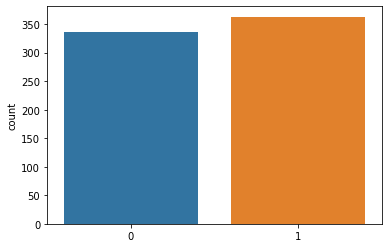

In [18]:
sns.countplot(list(sents_data['has_def']))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


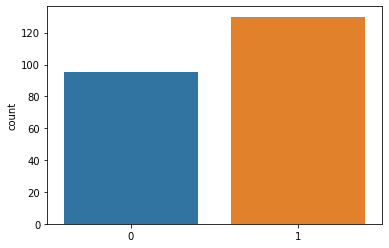

In [19]:
sns.countplot(list(sents_data_test['has_def']))

In [20]:
from statistics import mean
lens = [len(i) for i in list(sents_data['sent_text'])]
mean(lens)

175.53428571428572

### Датасет

In [21]:
class SentsDataset(Dataset):

  def __init__(self, sents, targets, tokenizer, max_len):
    self.sents = sents
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.sents)
  
  def __getitem__(self, item):
    sent = str(self.sents[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      sent,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    return {
      'sent_text':sent,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [22]:
RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [23]:
df_train, df_test = train_test_split(sents_data, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(sents_data_test, test_size=0.5, random_state=RANDOM_SEED)

In [24]:
MAX_LEN = 512

### DataLoader

In [25]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = SentsDataset(
    sents=df.sent_text.to_numpy(),
    targets=df.has_def.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=1
  )

In [26]:
BATCH_SIZE = 8

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [27]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['sent_text', 'input_ids', 'attention_mask', 'targets'])

### Класс SentsClassifier

In [28]:
class SentsClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentsClassifier, self).__init__()
    self.bert = BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME)
  
  def forward(self, input_ids, attention_mask):
    output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False)
    return output[0]

In [29]:
model = SentsClassifier(2)
model = model.to(device)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were n

### Обучаем

In [30]:
EPOCHS = 2

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [31]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [32]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      
      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [33]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/2
----------
Train loss 0.3629044099516365 accuracy 0.8793650793650793
Val loss 0.23860344623348542 accuracy 0.9017857142857142

Epoch 2/2
----------
Train loss 0.13060517928745785 accuracy 0.9619047619047619
Val loss 0.40856251939632265 accuracy 0.9196428571428571

CPU times: user 4min 18s, sys: 9.18 s, total: 4min 28s
Wall time: 4min 29s


### Смотрим метрики

In [34]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.9203539823008849

Ура! Выглядит неплохо...

In [35]:
import torch.nn.functional as F

In [36]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  sent_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["sent_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      sent_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return sent_texts, predictions, prediction_probs, real_values

In [37]:
y_sent_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [38]:
print(classification_report(y_test, y_pred, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91        47
           1       0.94      0.92      0.93        66

    accuracy                           0.92       113
   macro avg       0.92      0.92      0.92       113
weighted avg       0.92      0.92      0.92       113



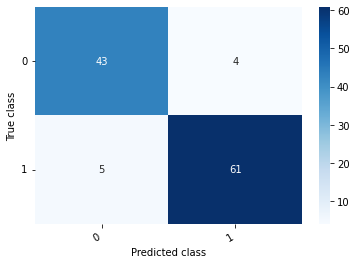

In [39]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True class')
  plt.xlabel('Predicted class');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=['0', '1'], columns=['0', '1'])
show_confusion_matrix(df_cm)

### Тестируем на каком-либо предложении

In [40]:
def predict(model, sentence):
    df = pd.DataFrame({'sent_index': [0], 'sent_text': [sentence], 'has_def': [1]})
    test_data_loader = create_data_loader(df, tokenizer, MAX_LEN, BATCH_SIZE)
    y_sent_texts, y_pred, y_pred_probs, y_test = get_predictions(
        model,
        test_data_loader)
    return y_pred[0]

In [79]:
predict(model, 'Лингвистика - это наука о языках, изучающая их как систему.')

tensor(1)

# CRF

In [1]:
!pip install stanza

In [2]:
!pip install sklearn_crfsuite

In [3]:
!pip install -U 'scikit-learn<0.24'

In [4]:
! pip install natasha

In [5]:
from sklearn.model_selection import train_test_split
import stanza
from collections import defaultdict
from tqdm.notebook import tqdm
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from sklearn.model_selection import cross_val_score
from collections import Counter
import pandas as pd
import seaborn as sns
from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    NamesExtractor,

    Doc
)

segmenter = Segmenter()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

### Готовим файлы

In [58]:
df_sents = pd.read_csv('sents_Wiki_tagged.csv', dtype={'sent_index': str, 'sent_text': str, 'def': int}, sep=';')
sents_filtered = df_sents[df_sents['def'] > 0]
sents = list(sents_filtered['sent_text'])
ids = list(sents_filtered['sent_index'])

In [59]:
train_sents, dev_sents, train_ids, dev_ids = train_test_split(sents, ids)

In [60]:
df_tokens = pd.read_csv('tokens_Wiki_tagged.csv', dtype={'sent_index': str, 'token': str, 'tag': str}, sep=';')
tokens_filtered = df_tokens[df_tokens['sent_index'].isin(ids)]
tokens = list(tokens_filtered['token'])
t_ids = list(tokens_filtered['sent_index'])

In [61]:
def bio_sents(sents_ids, tokens_df):
    bio_sents = {}
    for i in sents_ids:
        bio_sents[i] = list(tokens_df.loc[tokens_df['sent_index']==i]['tag'])
    return bio_sents

In [62]:
bio_sents_train = bio_sents(train_ids, df_tokens)
bio_sents_test = bio_sents(dev_ids, df_tokens)

In [63]:
def get_bert_ebm(word):
    encoding = tokenizer.encode_plus(
        word,
        max_length=30,
        add_special_tokens=True, # Добавить '[CLS]' и '[SEP]'
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',  # Вернуть тензор PyTorch
        truncation=True)
    outputs = model(
        input_ids=encoding['input_ids'].to(device), 
        attention_mask=encoding['attention_mask'].to(device))
    return outputs.cpu().detach().numpy()

In [64]:
def word2features(sent, i):
    word = sent[i].text
    postag = sent[i].pos
    
    features = {
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag
    }
    for iv,value in enumerate(get_bert_ebm(word)[0]):
        features['v{}'.format(iv)] = value
    if i > 0:
        word1 = sent[i-1].text
        postag1 = sent[i-1].pos
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1
        })
        for iv,value in enumerate(get_bert_ebm(word1)[0]):
            features['-1v{}'.format(iv)] = value
    else:
        features['BOS'] = True
        
    if i < len(sent)-1:
        word1 = sent[i+1].text
        postag1 = sent[i+1].pos
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2]
        })
        for iv,value in enumerate(get_bert_ebm(word1)[0]):
            features['+1v{}'.format(iv)] = value
    else:
        features['EOS'] = True
                
    return features


def text2features(text):
    doc = Doc(text)
    sentences = doc.segment(segmenter)
    m = doc.tag_morph(morph_tagger)
    toks = []
    for tok in doc.tokens:
        toks.append(tok)
    return [word2features(toks, i) for i in range(len(toks))]

def text2labels(text_ids, labels):
    return [labels[i] for i in text_ids]

def text2tokens(text):
    doc = Doc(text)
    sentences = doc.segment(segmenter)
    toks = []
    for sent in sentences:
      for tok in doc.tokens:
        toks.append(tok)
    return toks

In [65]:
X_train = [text2features(s) for s in train_sents]
y_train = text2labels(train_ids, bio_sents_train)

X_test = [text2features(s) for s in dev_sents]
y_test = text2labels(dev_ids, bio_sents_test)

### Запускаем CRF

In [66]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    c1=0.1, 
    c2=0.1, 
    max_iterations=100, 
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100)

### Смотрим метрики

In [67]:
labels = list(crf.classes_)
labels.remove('O')
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred, 
                      average='weighted', labels=labels)

0.8992867336251428

In [68]:
sorted_labels = sorted(
    labels, 
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

       B-DEF      0.890     0.819     0.853       138
       I-DEF      0.855     0.988     0.917      2383
      B-TERM      0.922     0.776     0.843       152
      I-TERM      0.802     0.606     0.691       127

   micro avg      0.857     0.951     0.902      2800
   macro avg      0.867     0.797     0.826      2800
weighted avg      0.858     0.951     0.899      2800



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['B-DEF', 'I-DEF', 'B-TERM', 'I-TERM'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


### Тестируем на каком-либо предложении

In [74]:
crf.predict(text2features(s) for s in ['Любовь - это великое искусство.'])

[['B-TERM', 'O', 'O', 'B-DEF', 'I-DEF', 'O']]

# Тестируем всё вместе на каком-либо предложении

In [70]:
def predict_labels(inp):
    cls = predict(model, inp).numpy()
    if cls == 0:
        return 'Терминов и определений нет'
    else:
        return crf.predict(text2features(s) for s in [inp])

In [71]:
predict_labels('Обычно в биологии систематику трактуют как раздел знаний о разнообразии организмов и взаимоотношениях между ними, а таксономию как раздел науки, изучающий принципы, методы и правила классификации.')

'Терминов и определений нет'

In [72]:
predict_labels('Принципы таксономии применяются во многих научных областях знаний, для упорядочивания объектов географии, геологии, языкознания, этнографии и всего многообразия органического мира.')

'Терминов и определений нет'

In [78]:
predict_labels('Лингвистикой называют науку о языке, рассматривающую язык как систему.')

[['B-TERM',
  'O',
  'B-DEF',
  'I-DEF',
  'I-DEF',
  'I-DEF',
  'I-DEF',
  'I-DEF',
  'I-DEF',
  'I-DEF',
  'O']]